Machine Learning Exam gegre

This is a classification task.
The two different machine learning models chosen are Linear SVM and Random forest

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

The dataset is loaded and preprocessed

In [50]:

# Load the dataset
data = pd.read_csv('C:/Users/User/Documents/GitHub/ML_exam/ai4i2020.csv')

# Display the first 5 rows of the data
print(data.head())
print(data.info())


   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [51]:
# Check if there are missing values in the dataset
if data.isnull().values.any():
    print("Missing values found")
else:
    print("No missing values found")

# Preprocess the data
X = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure'])
y = data['Machine failure']


No missing values found


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standardize the features

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Initializing the SVM classifier using both linear and rbf kernels to see which one is best

In [54]:
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')

Performing k-fold cross-validation instead of splitting the dataset before

In [55]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [56]:
# Cross-validation for linear kernel
linear_cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=kf)
print(f"Linear Kernel - Cross-validation scores: {linear_cv_scores}")
print(f"Linear Kernel - Mean cross-validation score: {linear_cv_scores.mean()}")

# Cross-validation for RBF kernel
rbf_cv_scores = cross_val_score(rbf_svm, X_train, y_train, cv=kf)
print(f"RBF Kernel - Cross-validation scores: {rbf_cv_scores}")
print(f"RBF Kernel - Mean cross-validation score: {rbf_cv_scores.mean()}")

Linear Kernel - Cross-validation scores: [0.999375 0.99875  0.99875  0.999375 0.999375]
Linear Kernel - Mean cross-validation score: 0.999125
RBF Kernel - Cross-validation scores: [0.999375 0.99875  0.99875  0.999375 0.999375]
RBF Kernel - Mean cross-validation score: 0.999125


As seen in the results, it doesn't matter if it's linear or RBF kernel

Now training the SVM with the linear kernel on the entire dataset and evaluating it on the test set. Using the linear kernel is less heavy to compute

In [57]:
linear_svm.fit(X_train, y_train)

SVC(kernel='linear')

Now for the prediction

In [58]:
y_pred = linear_svm.predict(X_test)

And the evaluation

In [59]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.999
Precision: 1.0
Recall: 0.9672131147540983
F1 Score: 0.9833333333333333
ROC AUC: 0.9836065573770492
Confusion Matrix:
[[1939    0]
 [   2   59]]


The next model implemented is Random Forest

In [60]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Predictions

In [61]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUC score


Evaluating the Random Forest model (accuracy, precision, recall, f1-score, ROC-AUC)

In [62]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_pred_prob),
}

Making a confusion matrix

In [63]:

# Confusion Matrix: Table showing correct and incorrect predictions by class
conf_matrix = confusion_matrix(y_test, y_pred)


Feature importance. This shows how much each feature contributes to the model's decisions

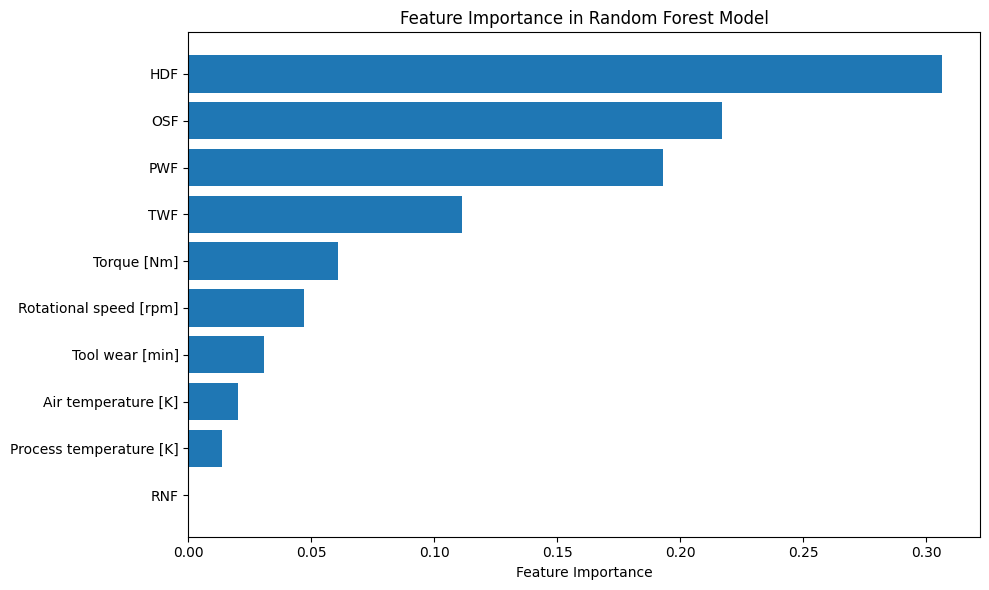


Feature Importance:
RNF: 0.0003
Process temperature [K]: 0.0136
Air temperature [K]: 0.0200
Tool wear [min]: 0.0307
Rotational speed [rpm]: 0.0469
Torque [Nm]: 0.0609
TWF: 0.1112
PWF: 0.1930
OSF: 0.2168
HDF: 0.3065


In [65]:

feature_importance = rf_model.feature_importances_
feature_names = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure']).columns


sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

# Print feature importance
print("\nFeature Importance:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importance[i]:.4f}")